In [2]:
import torch
import torch_geometric_temporal
import json
import numpy as np
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
import os
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)
torch.manual_seed(0)

In [3]:
# seed

np.random.seed(0)
torch.manual_seed(0)
# torch_geometric_temporal.seed(0)

In [4]:
# define the number of features
feature_num = 3

# DAILY
start_col = 1

# HOURLY
# start_col = 2

# define the number of time steps
time_step = 5

In [5]:
directory = 'Dataset/'

node_num = 0
dataset = []

# read csv files in Dataset folder
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        node_num += 1
        node = pd.read_csv(directory + filename).iloc[:, start_col: start_col + feature_num].values
        dataset.append(node)
        print(filename)

dataset = np.array(dataset)


cleaned_data_10.csv
cleaned_data_1.csv
cleaned_data_0.csv
cleaned_data_2.csv
cleaned_data_3.csv
cleaned_data_7.csv
cleaned_data_6.csv
cleaned_data_4.csv
cleaned_data_5.csv
cleaned_data_8.csv
cleaned_data_9.csv


In [6]:
dataset.shape

(11, 1095, 3)

In [7]:
# mean, max, average of features
d = dataset

print('CO', d[:, :, 0].mean(), d[:, :, 0].max(), d[:, :, 0].min())
print('SO2', d[:, :, 1].mean(), d[:, :, 1].max(), d[:, :, 1].min())
print('PM10', d[:, :, 2].mean(), d[:, :, 2].max(), d[:, :, 2].min())

CO 1.5835646155588556 7.02246525 0.16313125
SO2 5.963400870573127 58.03220945 0.30258259
PM10 81.40567118700736 851.31971804 1.98500036


In [8]:
print(dataset[0][0])

[ 1.18206846  2.27336876 33.90688519]


In [9]:
# dataset = dataset.reshape(node_num, feature_num, -1)
# dataset[0][0]

In [10]:
dataset.shape

(11, 1095, 3)

In [11]:
edges = [[], []]
for i in range(node_num):
    for j in range(node_num):
        edges[0].append(i)
        edges[1].append(j)

edges = np.array(edges)

# one weight for edges
edge_weight = np.ones(edges[0].shape)


In [12]:
# dataset: (time, feature, node)
# edge_weight: (edge)

# print shapes
print(dataset.shape)
print(edges.shape)
print(edge_weight.shape)

(11, 1095, 3)
(2, 121)
(121,)


In [13]:
time_step = 4

# targets are in dataset after timestep
features_co = []
features_so2 = []
features_pm10 = []

targets_co = []
targets_so2 = []
targets_pm10 = []
for i in range(dataset.shape[1] - time_step):
    features_co.append(dataset[:, i:i + time_step, 0])
    features_so2.append(dataset[:, i:i + time_step, 1])
    features_pm10.append(dataset[:, i:i + time_step, 2])

    targets_co.append(dataset[:, i + time_step, 0])
    targets_so2.append(dataset[:, i + time_step, 1])
    targets_pm10.append(dataset[:, i + time_step, 2])


features_co = np.array(features_co)
features_so2 = np.array(features_so2)
features_pm10 = np.array(features_pm10)

targets_co = np.array(targets_co)
targets_so2 = np.array(targets_so2)
targets_pm10 = np.array(targets_pm10)

In [14]:
print('feature shape:', features_co.shape)
print('target shape:', targets_co.shape)

feature shape: (1091, 11, 4)
target shape: (1091, 11)


In [15]:
# max, min, average of CO targets
print(targets_co.max(), targets_co.min(), targets_co.mean())

7.02246525 0.16313125 1.5861364917220577


In [16]:
spatio = StaticGraphTemporalSignal(
    edges,
    edge_weight,
    features_co,
    targets_co
)

In [17]:
# batch iterator
from torch_geometric_temporal import StaticGraphTemporalSignalBatch

batch_size = 20
spatio_loader = StaticGraphTemporalSignalBatch(edges, edge_weight, features_co, targets_co, batch_size)


In [18]:
# # save loader
# import pickle

# with open('loader.pkl', 'wb') as f:
#     pickle.dump(spatio_loader, f)
    

In [19]:
from torch_geometric_temporal.signal import temporal_signal_split

train_dataset, test_dataset = temporal_signal_split(spatio_loader, train_ratio=0.7)

In [20]:
for i in train_dataset:
    print(i)
    break

DataBatch(x=[11, 4], edge_index=[2, 121], edge_attr=[121], y=[11], batch=[20])


In [1]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric_temporal import GConvGRU

class RecurrentGCN(torch.nn.Module):
    def __init__(self, time_step):
        print(x.shape)
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(time_step, 32, 8)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [167]:
from torch_geometric.nn import GCNConv, TransformerConv

feature_num = 1

# Define your model architecture:
class GCNTransformer(torch.nn.Module):
    weight =[]
    def __init__(self, time_step, feature_num):
        super(GCNTransformer, self).__init__()
        self.gcn1 = GCNConv(feature_num * time_step, 6 * time_step)
        self.gcn2 = GCNConv(6 * time_step, 6 * time_step)
        # self.gcn3 = GCNConv(12 * time_step, 6 * time_step)
        self.transformer1 = TransformerConv(6 * time_step, 1, heads= 3 * time_step, dropout=0.3)
        self.transformer2 = TransformerConv(3 * time_step, 1, heads= 1, dropout=0.3)
        # self.transformer3 = TransformerConv(3, 1, heads= 1, dropout=0.3)

    def forward(self, x, edge_index, edge_weight):
 
        x = self.gcn1(x, edge_index, edge_weight)
        x = F.relu(x)
        # x = x.view(-1, x.size(-1))

        x = self.gcn2(x, edge_index, edge_weight)
        # # x = self.gcn3(x, edge_index)
        x = F.relu(x)

        # x = self.gcn3(x, edge_index)
        # x = F.relu(x)

        x = self.transformer1(x, edge_index)
        x = F.relu(x)
        # combine res1 and res2, with size
        # size: 2*feature and 2*feature 
        # x = torch.cat((res1, res2), 1)

        x = self.transformer2(x, edge_index)
        # x = F.relu(x)

        # x = self.transformer3(x, edge_index)

        return x

    
# Instantiate your model:
# model = MyModel(gcn1, gcn2, gcn3, transformer1, transformer2)



In [168]:
# from torch_geometric_temporal import GConvGRU
# model = GConvGRU(3, 1, 5)

In [169]:
# from tqdm import tqdm

# model = RecurrentGCN(node_features = time_step)


# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# model.train()
# losses = []
# for epoch in tqdm(range(150)):
#     cost = 0
#     for time, snapshot in enumerate(train_dataset):
#         y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
#         cost = cost + torch.mean((y_hat-snapshot.y)**2)
#     cost = cost / (time+1)
#     losses.append(cost.detach().numpy())
#     cost.backward()
#     optimizer.step()
#     optimizer.zero_grad()

In [170]:
# model.eval()
# loss_test = []
# cost = 0
# for time, snapshot in enumerate(test_dataset):
#     y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
#     c = torch.mean((y_hat-snapshot.y)**2)
#     loss_test.append(c.detach().numpy())
#     cost = cost + c
# cost = cost / (time+1)
# cost = cost.item()
# print("MSE: {:.4f}".format(cost))

In [171]:
# train over train_datset batches
from torch.optim import Adam
from tqdm import tqdm

model = RecurrentGCN(time_step = time_step)
# model = GCNTransformer(time_step, feature_num)

optimizer = Adam(model.parameters(), lr=0.005)
model.train()

epoch_num = 300

losses = [[] for i in range(epoch_num)]

y_pred = [[] for i in range(epoch_num)]

for epoch in tqdm(range(epoch_num)):    
    for i, batch in enumerate(train_dataset):
        
        out = model(batch.x, batch.edge_index, batch.edge_attr)
        y_pred[epoch].append(out)
        loss = F.mse_loss(out, batch.y)

        losses[epoch].append(loss.item())
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        # if (i+1) % 400 == 0:
        #     print(f'Epoch [{epoch+1}/{epoch_num}], Step [{i+1}], Loss: {loss.item()}')
    
    # print(loss)

  0%|          | 0/300 [00:00<?, ?it/s]/var/folders/h8/mhwh4fjn0qj405sjdd9_5ffw0000gn/T/ipykernel_6542/1962234902.py:22: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, batch.y)
100%|██████████| 300/300 [18:12<00:00,  3.64s/it]


In [172]:
losses = np.array(losses)

counter = 0
for i in range(losses.shape[0]):
    for j in range(losses.shape[1]):
        if losses[i][j] > 1:
            # print(f'losses[{i}][{j}] =', losses[i][j])
            counter += 1

print('counter =', counter)
losses.shape

counter = 18878


(300, 763)

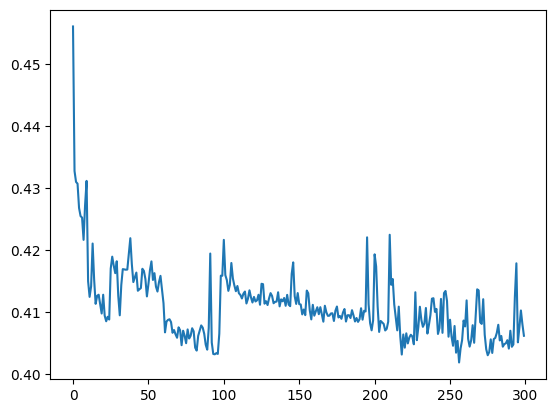

In [173]:
mean_loss = np.mean(losses, axis=1)

plt.plot(mean_loss)

In [174]:
model.eval()
loss_test = []
y_pred_test = []
y_true_test = []
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    
    y_pred_test.append(y_hat.detach().numpy())
    y_true_test.append(snapshot.y.detach().numpy())

    c = F.mse_loss(y_hat, snapshot.y)
    loss_test.append(c.detach().numpy())
    cost = cost + c
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

/var/folders/h8/mhwh4fjn0qj405sjdd9_5ffw0000gn/T/ipykernel_6542/2912938829.py:12: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  c = F.mse_loss(y_hat, snapshot.y)


MSE: 0.4118


In [175]:
# plot y_pred and y_true
y_pred_test_mean = np.array(y_pred_test).reshape(-1, node_num).mean(axis=1).flatten()
y_true_test_mean = np.array(y_true_test).reshape(-1, node_num).mean(axis=1).flatten()

print('shape: ', y_pred_test_mean.shape)
print('shape: ', y_true_test_mean.shape)

shape:  (328,)
shape:  (328,)


<AxesSubplot:>

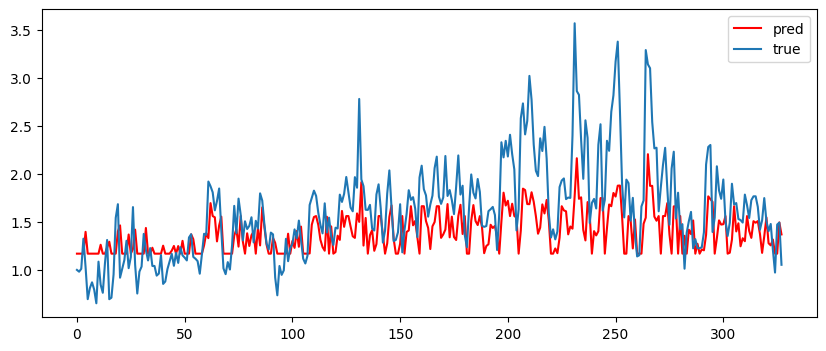

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))
sns.lineplot(data=y_pred_test_mean, label="pred", color='red')
sns.lineplot(data=y_true_test_mean, label="true")

In [177]:
# Calc MAPE
y_pred_test = np.array(y_pred_test)
y_true_test = np.array(y_true_test).flatten()


mape = np.mean(np.abs((y_true_test - y_pred_test) / y_true_test)) * 100
print("MAPE: {:.4f}".format(mape))

MAPE: 33.7482


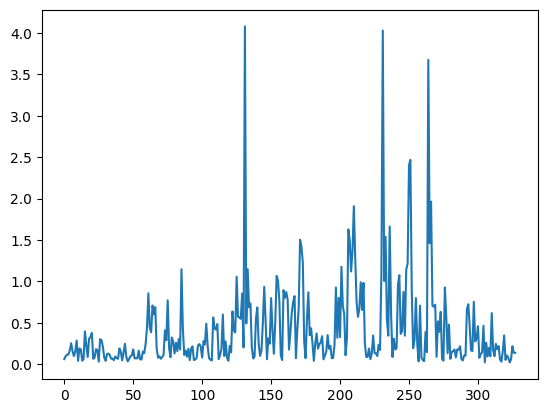

In [178]:
# plot loss
import matplotlib.pyplot as plt
plt.plot(loss_test)

In [179]:
# mean loss in each epoch
losses_mean = [np.mean(i) for i in losses]

for i in range(epoch_num):
    print(f'epoch [{i}/{epoch_num}] :', losses_mean[i])


epoch [0/300] : 0.4561137877878285
epoch [1/300] : 0.4327855196001489
epoch [2/300] : 0.4310257966223699
epoch [3/300] : 0.43073687463422666
epoch [4/300] : 0.4268174663962379
epoch [5/300] : 0.4255121980023572
epoch [6/300] : 0.4252615771958236
epoch [7/300] : 0.421669100309926
epoch [8/300] : 0.42728885650991183
epoch [9/300] : 0.43119106297460563
epoch [10/300] : 0.41500063490752387
epoch [11/300] : 0.4124691061428986
epoch [12/300] : 0.41417134350085166
epoch [13/300] : 0.42107963923799413
epoch [14/300] : 0.41528567022169166
epoch [15/300] : 0.41134528229245
epoch [16/300] : 0.4126355220950642
epoch [17/300] : 0.41281582470763556
epoch [18/300] : 0.41125804140094574
epoch [19/300] : 0.40978424240582345
epoch [20/300] : 0.4128145942974684
epoch [21/300] : 0.4094391022045971
epoch [22/300] : 0.40853141560457246
epoch [23/300] : 0.4092577612662241
epoch [24/300] : 0.4088116926672047
epoch [25/300] : 0.4170341370810375
epoch [26/300] : 0.41895723170057664
epoch [27/300] : 0.4175103136